# Distracted driver detection

According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year.

## Step 0: Defining the problem
**Goal** : Predict the likelihood of what the driver is doing in each picture.  
**Evaluation** : Submissions are evaluated using the multi-class logarithmic loss.  

## Step 1: Setup helper functions and config variables

In [1]:
# Importing necessary functions and libraries
from datetime import date
import typing as t
import warnings
import os
import pathlib
import random
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import (
    models,
    layers,
    applications,
    preprocessing,
    optimizers,
    callbacks,
)
from mlxtend import plotting
from tqdm.auto import tqdm

warnings.simplefilter("ignore")

In [2]:
# Creating utility helper functions
def show_random_samples(
    directory_path: t.Union[pathlib.Path, str], label: str, num_of_samples: int = 5
) -> None:
    """
    Shows sample of images from a directory belonging to a class

    Args:
        directory_path (t.Union[pathlib.Path, str]): Path of the parent directory where `label` is located
        label (str): Class label of the image
        num_of_samples (int, optional): Number of samples to show. Defaults to 5.
    """
    files = os.listdir(os.path.join(directory_path, label))
    plt.figure(figsize=(10, 12))
    plt.subplots_adjust(wspace=2)
    for i in range(num_of_samples):
        plt.subplot(1, num_of_samples, i + 1)
        sample = random.choice(files)
        sample_path = os.path.join(os.path.join(directory_path, label), sample)
        img = mpimg.imread(sample_path)
        imgplot = plt.imshow(img)
        plt.axis(False)
        plt.title(f"{label.lower().capitalize()}\n{img.shape}")
    plt.show()


def create_class_weight(label_count_dict: t.Dict[str, int]) -> t.Dict[int, float]:
    """
    Creates class weights, optimally used for imbalanced data

    Args:
        label_count_dict (t.Dict[str, int]): Dictionary in the format {`label` : `count`}

    Returns:
        t.Dict[int, float]: Class weights dictionary in the format {`label` : `weight`}
    """
    total_samples = np.sum(list(label_count_dict.values()))
    labels = label_count_dict.keys()
    class_weights = dict()

    for idx, label in enumerate(labels):
        class_weights[idx] = float(
            total_samples / (len(list(labels)) * label_count_dict[label])
        )

    return class_weights


def create_model_checkpoint(
    model_name: str, directory: str = "models/"
) -> tf.keras.callbacks.ModelCheckpoint:
    """
    Returns a model checkpoint callback ro save the best model while training

    Args:
        model_name (str): Name of the model, functions creates a directory for the model of this name
        save_path (str, optional): Main directory to store all weights. Defaults to "model_experiments".

    Returns:
        tf.keras.callbacks.ModelCheckpoint: A callback to get the best model configuration according to the training.
    """
    directory = pathlib.Path(directory)
    directory.mkdir(parents=True, exist_ok=True)
    filepath = directory / f"{model_name}.h5"
    return callbacks.ModelCheckpoint(
        filepath=filepath, verbose=1, save_best_only=True, save_weights_only=False
    )


def create_early_stopping(
    patience: int = 3, restore_best_weights: bool = True
) -> tf.keras.callbacks.EarlyStopping:
    """
    Returns a early stopping callback

    Args:
        patience (int, optional): Number of iterations to look for improvement. Defaults to 3.
        restore_best_weights (bool, optional): Restore best weights. Defaults to True.

    Returns:
        tf.keras.callbacks.EarlyStoppin: A callback to stop training if the validation loss does not decrease.
    """
    return callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=restore_best_weights,
    )


def plot_loss_curves(history: tf.keras.callbacks.History) -> None:
    """
    Shows separate loss curves for training and validation metrics.

    Args:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.figure(figsize=(19, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.legend(loc="upper right")

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.legend(loc="upper left")


def plot_conf_matrix(
    y_true: npt.ArrayLike, y_pred: npt.ArrayLike, classes: list
) -> None:
    """
    Plots confusion matrix

    Args:
        y_true (npt.ArrayLike): True labels
        y_pred (npt.ArrayLike): Pred labels
        classes (list): List with names of classes
    """
    cnf_matrix = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    plotting.plot_confusion_matrix(
        conf_mat=cnf_matrix, class_names=classes, figsize=(10, 7)
    )


def get_metrics(
    y_true: npt.ArrayLike,
    y_pred: npt.ArrayLike,
    model_path: pathlib.Path,
    classes: list,
    plot_confusion_matrix: bool = False,
) -> t.Dict[str, float]:
    """
    Generates classification metrics, optionally shows confusion matrix

    Args:
        y_true (npt.ArrayLike): True labels, make sure the arrays are flattened!
        y_pred (npt.ArrayLike): Predicted labels, make sure the arrays are flattened!
        plot_confusion_matrix (bool, optional): Shows confusion matrix. Defaults to False.

    Raises:
        ValueError: When shape of `y_test` and `y_pred` are not the same.

    Returns:
        t.Dict[str, float]: Classification metrics
    """
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch error!")

    y_true, y_pred = y_true.flatten(), y_pred.flatten()

    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average="micro")
    recall = metrics.recall_score(y_true, y_pred, average="micro")
    f1_score = metrics.f1_score(y_true, y_pred, average="micro")

    if plot_confusion_matrix:
        plot_conf_matrix(y_true, y_pred, classes=classes)

    # Model file size in MBs
    model_size = model_path.stat().st_size // (1024**2)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1_score,
        "Size (MB)": model_size,
    }


def load_and_prep_image(filename: pathlib.Path, img_shape: int = 224):
    """
    Returns an image tensor by reading the image on `filepath`

    Args:
        filename (pathlib.Path): Filepath of a single image
        img_shape (int, optional): Image dimension. This is considered as both height and width of image for resizing. Defaults to 224.

    Returns:
        tf.Tensor: Image as a tensor
    """
    # Read in the image
    img = tf.io.read_file(filename)
    # Decode it into a tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, [img_shape, img_shape])
    return img


def create_submission_csv(
    dataloader,
    model: tf.keras.models.Model,
    save_path: pathlib.Path,
    submission_csv_path: pathlib.Path,
) -> None:
    """
    Creates a submission file `.csv` to submit to the competition

    Args:
        dataloader: dataloader to iterate over and predict
        model (`tf.keras.models.Model`): Model to predict on
        save_path (`pathlib.Path`): File/directory path to save the file
        submission_csv_path(`pathlib.Path`): File path to the sample submission csv file

    """

    today = date.today().strftime("%d_%m")

    preds = model.predict(dataloader, verbose=0)
    print("[INFO] Predictions on dataloader completed.")
    sample_submission_file = pd.read_csv(submission_csv_path)
    test_df = pd.DataFrame(
        columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"]
    )

    assert (
        preds.shape[0] == sample_submission_file.shape[0]
    ), f"[ERROR] Shapes of predictions and csv mismatched"

    submission_csv = sample_submission_file.drop(
        sample_submission_file.columns.difference(["img"]), axis=1
    )

    for idx in tqdm(range(preds.shape[0])):
        test_df = test_df.append(
            pd.Series(
                preds[idx].tolist(), index=test_df.columns[: len(preds[idx].tolist())]
            ),
            ignore_index=True,
        )

    submission_csv = pd.concat([submission_csv, test_df], axis=1)

    save_path.mkdir(parents=True, exist_ok=True)
    save_file_path = save_path / f"{model.name}_{today}.csv"
    print(
        f"[INFO] Saving submissions... File located at {save_path}/{model.name}_{today}.csv"
    )
    submission_csv.to_csv(save_file_path, index=False)

In [3]:
# Defining config variables
class CONFIG:
    train_path = pathlib.Path(
        "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"
    )
    test_path = pathlib.Path(
        "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"
    )
    classes = [
        "c0",
        "c1",
        "c2",
        "c3",
        "c4",
        "c5",
        "c6",
        "c7",
        "c8",
        "c9",
    ]
    num_classes = len(classes)
    image_size = 224
    verbose = 1
    batch_size = 32
    autotune = tf.data.AUTOTUNE
    seed = 42
    submission_dir = pathlib.Path("submissions")
    sample_submission_path = pathlib.Path(
        "/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv"
    )

## Step 2: Knowing more about data
- Display an example of the data
- Get the statistics of the data
- Check for data imbalance for training dataset
- (If required) Declare weights for model training, incase of data imbalance
- (If required) Create a data augmentation pipeline
- Make data processing faster for modelling using dataset generators

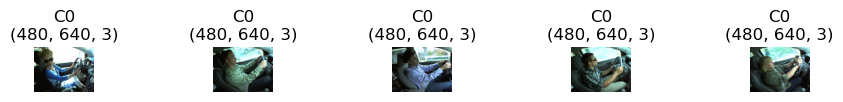

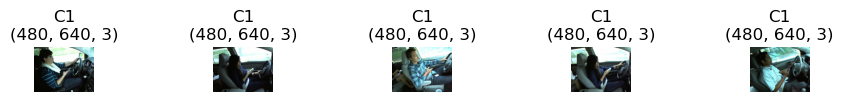

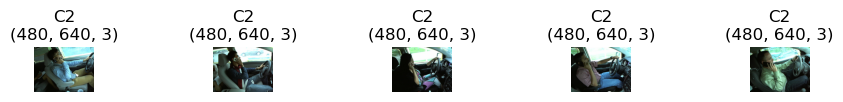

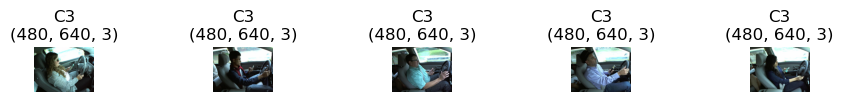

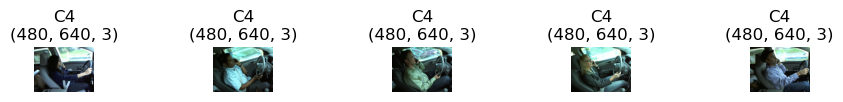

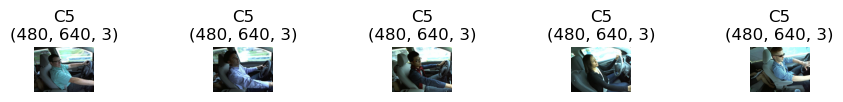

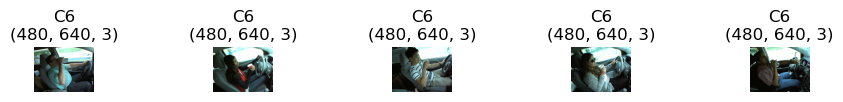

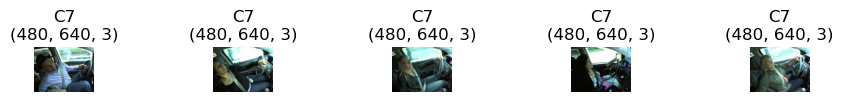

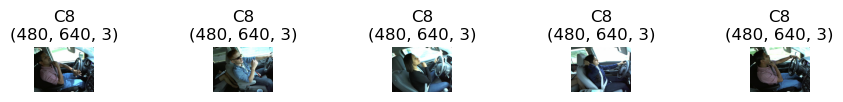

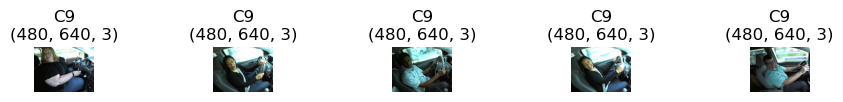

In [4]:
# Display random example of data
for idx, label in enumerate(CONFIG.classes):
    show_random_samples(CONFIG.train_path, label)

Image size: (480, 640, 3)
Maximum pixel value in the image: 255


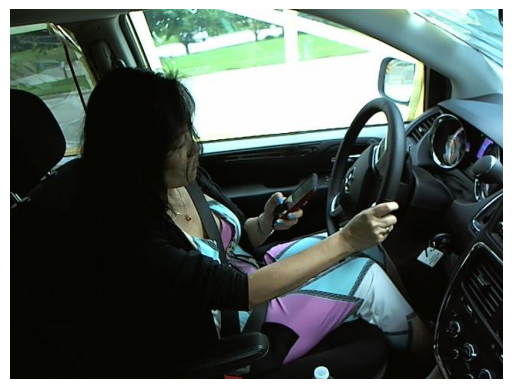

In [5]:
# Displaying a sample from image to get the statistics
image = mpimg.imread(
    "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3/img_100006.jpg"
)
print(f"Image size: {image.shape}")
print(f"Maximum pixel value in the image: {tf.math.reduce_max(image)}")
plt.imshow(image)
plt.axis(False)
plt.show()

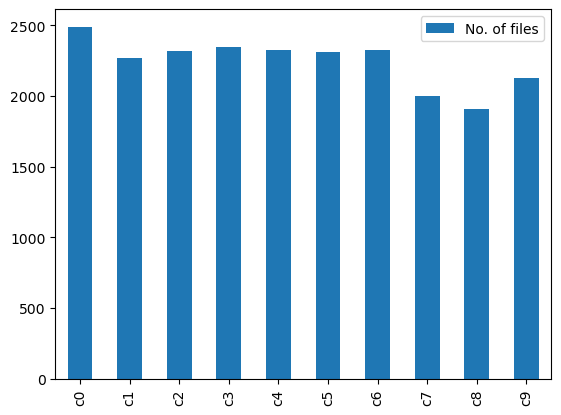

In [6]:
# Get the statistics about the data
data_count_dict = {}
for label in CONFIG.classes:
    data_count = len(os.listdir(os.path.join(CONFIG.train_path, label)))
    data_count_dict[label] = data_count

data_count_df = pd.DataFrame.from_dict(data_count_dict, orient="index").rename(
    columns={0: "No. of files"}
)
data_count_df.plot(kind="bar");

In [7]:
# To make data processing faster
datagen = preprocessing.image.ImageDataGenerator(
    zoom_range=0.2, rotation_range=20, horizontal_flip=True, validation_split=0.15
)

train_ds = datagen.flow_from_directory(
    directory=CONFIG.train_path,
    target_size=(CONFIG.image_size, CONFIG.image_size),
    batch_size=CONFIG.batch_size,
    class_mode="sparse",
    seed=CONFIG.seed,
    subset="training",
)

val_ds = datagen.flow_from_directory(
    directory=CONFIG.train_path,
    target_size=(CONFIG.image_size, CONFIG.image_size),
    batch_size=CONFIG.batch_size,
    class_mode="sparse",
    seed=CONFIG.seed,
    subset="validation",
    shuffle=False,
)

test_dataloader = tf.data.Dataset.list_files(str(CONFIG.test_path / "*.jpg"), shuffle=False)
test_dataloader = (
    test_dataloader.map(
        lambda x: load_and_prep_image(x, CONFIG.image_size),
        num_parallel_calls=CONFIG.autotune,
    )
    .batch(CONFIG.batch_size)
    .prefetch(1)
)

test_filepaths = []
for filepath in test_dataloader.list_files(str(CONFIG.test_path / "*.jpg"), shuffle=False):
    test_filepaths.append(filepath.numpy().decode("UTF-8"))

y_val_labels = val_ds.classes
class_indices = dict(map(reversed, val_ds.class_indices.items()))
print(f"[INFO] Data loaders and artifacts processed")

Found 19066 images belonging to 10 classes.
Found 3358 images belonging to 10 classes.
[INFO] Data loaders and artifacts processed


## Step 3: Describe modelling experiments

#### Process to follow when making models:
0. Set random seeds
1. Create the model architecture
2. Compile the model by defining loss function and optimizer
3. Train the model with validation split of 15%, and add appropriate callbacks
4. Plot the loss curves
5. Load in the best weights
6. Evaluate performance on whole validation data
7. Get metrics for training data
8. Create a submission file csv
9. Submit the file to the competition


#### Models to be made:
- Model 1: Fine-tuned **ResNet50**, validated on 15% training data
- Model 2: Fine-tuned **VGG16**, validated on 15% training data
- Model 3: Fine-tuned **InceptionResNetV2** validated on 15% training data
- Model 4: Fine-tuned **EfficientNetB0**, validated on 15% training data
- Model 5: Fine-tuned **EfficientNetB5** validated on 15% training data

### Model 1
***Architecture***: Fine-tuned ResNet50  
***Optimizer***: Adam optimizer with 0.0001 learning rate  
***Epochs*** : 50  
***Callbacks*** : Early stopping, Model checkpointing

In [8]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

# 1. Create the model
base_resnet_model = applications.resnet50.ResNet50(
    include_top=False, weights="imagenet"
)
base_resnet_model.trainable = False

LAYERS_TRAINALBLE = 10
for layer in base_resnet_model.layers[-LAYERS_TRAINALBLE:]:
    layer.trainable = True

model_1 = tf.keras.Sequential(
    [
        layers.Input(shape=INPUT_SHAPE),
        base_resnet_model,
        layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
        layers.Dense(1024, activation="relu", name="fcl1"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu", name="fcl2"),
        layers.Dropout(0.2),
        layers.Dense(CONFIG.num_classes, activation="softmax", name="output"),
    ],
    name="model_1_resnet_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_1.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_1 = model_1.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
    callbacks=[
        create_model_checkpoint(model_name=model_1.name),
        create_early_stopping(patience=3),
    ],
)

94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/10
596/596 [==============================] - ETA: 0s - loss: 1.3386 - accuracy: 0.5205
Epoch 1: val_loss improved from inf to 0.69911, saving model to models/model_1_resnet_ft.h5
596/596 [==============================] - 480s 790ms/step - loss: 1.3386 - accuracy: 0.5205 - val_loss: 0.6991 - val_accuracy: 0.7496
Epoch 2/10
596/596 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.7465
Epoch 2: val_loss improved from 0.69911 to 0.50172, saving model to models/model_1_resnet_ft.h5
596/596 [==============================] - 325s 546ms/step - loss: 0.7260 - accuracy: 0.7465 - val_loss: 0.5017 - val_accuracy: 0.8282
Epoch 3/10
596/596 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.8058
Epoch 3: val_loss improved from 0.50172 to 0.50082, saving model to models/model_1_resnet_ft.h5
596/596 [==============================] - 325s 545ms/step - loss: 0.5698 - accuracy: 0.8058 

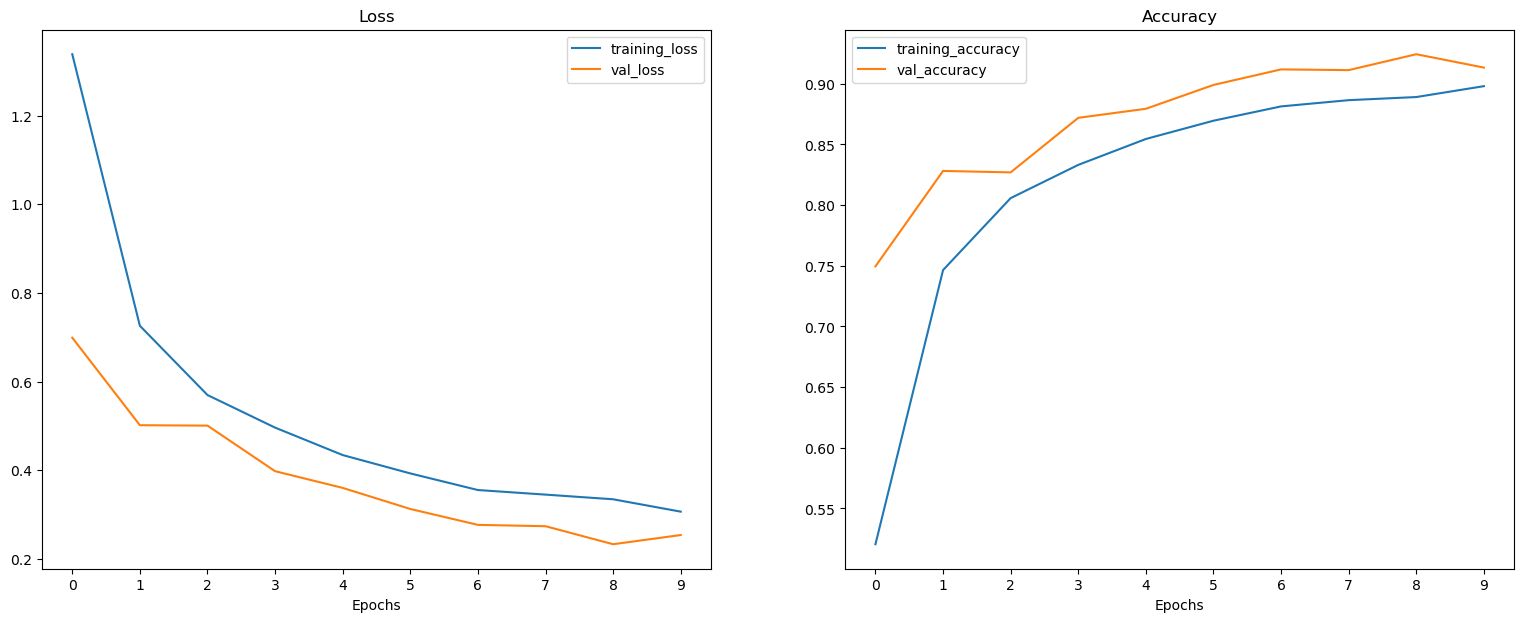

In [9]:
# 4. Plot model training performance
plot_loss_curves(history_model_1)

In [10]:
# 5. Loading the best weights
best_weights_path_model_1 = "/kaggle/working/models/model_1_resnet_ft.h5"
model_1 = models.load_model(best_weights_path_model_1)

In [ ]:
# 6. Evaluate on test data
model_1.evaluate(val_ds)

105/105 [==============================] - 49s 454ms/step


{'Accuracy': 0.9160214413341274,
 'Precision': 0.9160214413341274,
 'Recall': 0.9160214413341274,
 'F1-score': 0.9160214413341276,
 'Size (MB)': 117}

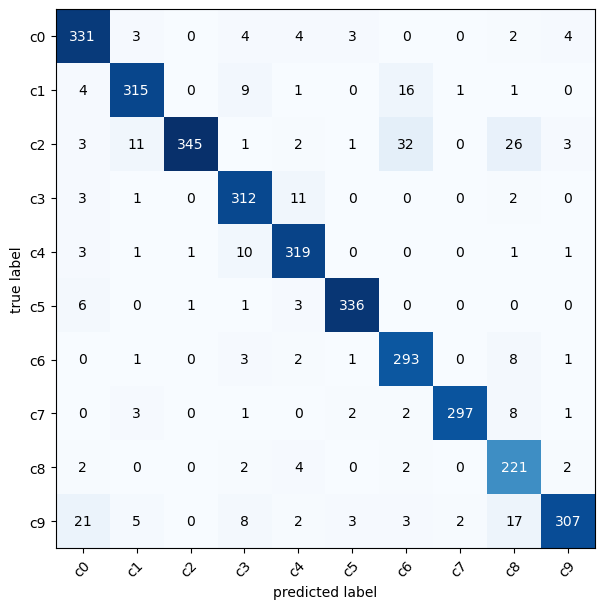

In [11]:
# 7. Get the model's performance metrics
model_1_pred_probs = model_1.predict(val_ds, verbose=1)
model_1_pred_classes = model_1_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_1_metrics = get_metrics(
    y_true=model_1_pred_classes,
    y_pred=y_val_labels,
    model_path=pathlib.Path(best_weights_path_model_1),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_1_metrics

In [12]:
# 8. Create submissions file
create_submission_csv(
    dataloader=test_dataloader,
    model=model_1,
    save_path=CONFIG.submission_dir,
    submission_csv_path=CONFIG.sample_submission_path,
)

[INFO] Predictions on dataloader completed.


  0%|          | 0/79726 [00:00<?, ?it/s]

[INFO] Saving submissions... File located at submissions/model_1_resnet_ft_08_01.csv


### Model 2
***Architecture***: Fine-tuned VGG16  
***Optimizer***: Adam optimizer with 0.0001 learning rate  
***Epochs*** : 50  
***Callbacks*** : Early stopping, Model checkpointing  

In [13]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

# 1. Create the model
base_vgg_model = applications.VGG16(include_top=False, weights="imagenet")
base_vgg_model.trainable = False

LAYERS_TRAINALBLE = 10
for layer in base_vgg_model.layers[-LAYERS_TRAINALBLE:]:
    layer.trainable = True

model_2 = tf.keras.Sequential(
    [
        layers.Input(shape=INPUT_SHAPE),
        base_vgg_model,
        layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
        layers.Dense(1024, activation="relu", name="fcl1"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu", name="fcl2"),
        layers.Dropout(0.2),
        layers.Dense(CONFIG.num_classes, activation="softmax", name="output"),
    ],
    name="model_2_vgg_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_2.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_2 = model_2.fit(
    train_ds,
    epochs=7,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
    callbacks=[
        create_model_checkpoint(model_name=model_2.name),
        create_early_stopping(patience=3),
    ],
)

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/7
596/596 [==============================] - ETA: 0s - loss: 1.7837 - accuracy: 0.3968
Epoch 1: val_loss improved from inf to 1.06732, saving model to models/model_2_vgg_ft.h5
596/596 [==============================] - 358s 593ms/step - loss: 1.7837 - accuracy: 0.3968 - val_loss: 1.0673 - val_accuracy: 0.6340
Epoch 2/7
596/596 [==============================] - ETA: 0s - loss: 0.9156 - accuracy: 0.6862
Epoch 2: val_loss improved from 1.06732 to 0.66583, saving model to models/model_2_vgg_ft.h5
596/596 [==============================] - 321s 538ms/step - loss: 0.9156 - accuracy: 0.6862 - val_loss: 0.6658 - val_accuracy: 0.7778
Epoch 3/7
596/596 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.7676
Epoch 3: val_loss improved from 0.66583 to 0.48275, saving model to models/model_2_vgg_ft.h5
596/596 [==============================] - 328s 550ms/step - loss: 0.6914 - accuracy: 0.7676 - val_loss: 

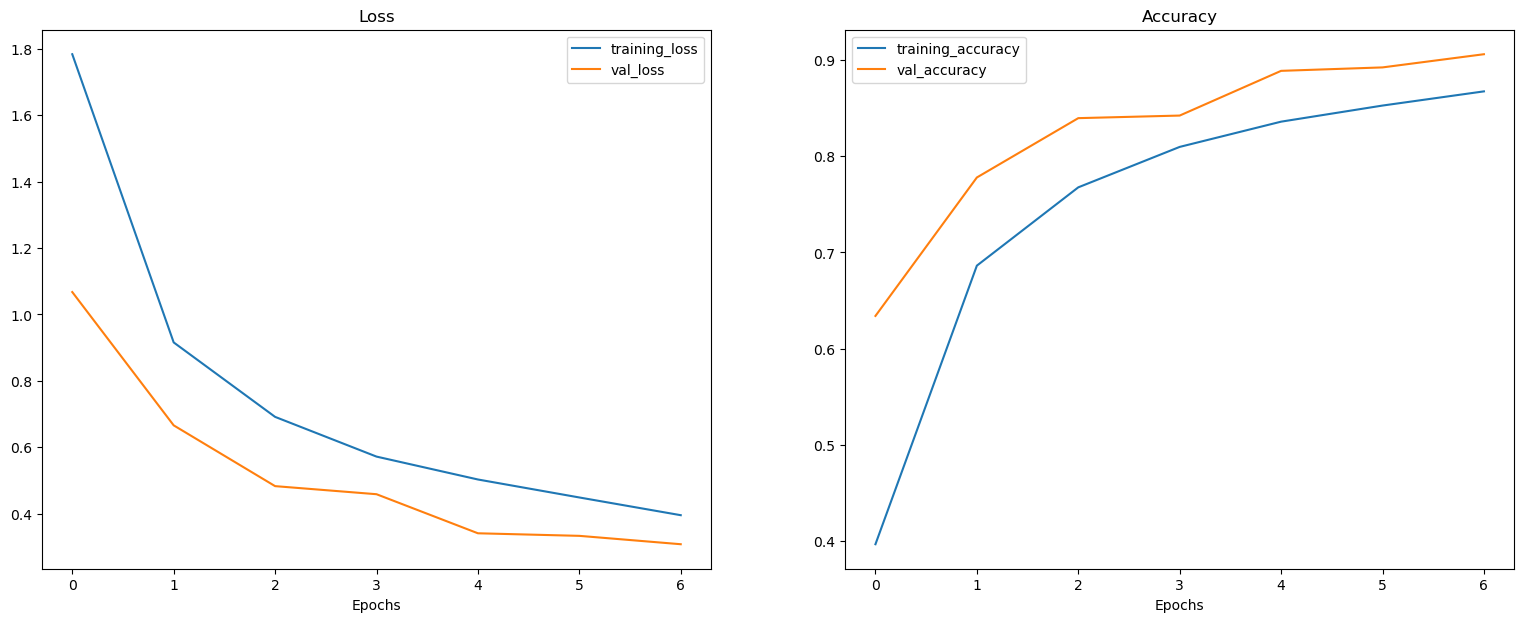

In [14]:
# 4. Plot model training performance
plot_loss_curves(history_model_2)

In [15]:
# 5. Loading the best weights
best_weights_path_model_2 = "/kaggle/working/models/model_2_vgg_ft.h5"
model_2 = models.load_model(best_weights_path_model_2)

In [16]:
# 6. Evaluate on test data
model_2.evaluate(val_ds)

105/105 [==============================] - 49s 463ms/step - loss: 0.3214 - accuracy: 0.9017


[0.32135388255119324, 0.9017271995544434]

105/105 [==============================] - 49s 461ms/step


{'Accuracy': 0.9094699225729601,
 'Precision': 0.9094699225729601,
 'Recall': 0.9094699225729601,
 'F1-score': 0.90946992257296,
 'Size (MB)': 65}

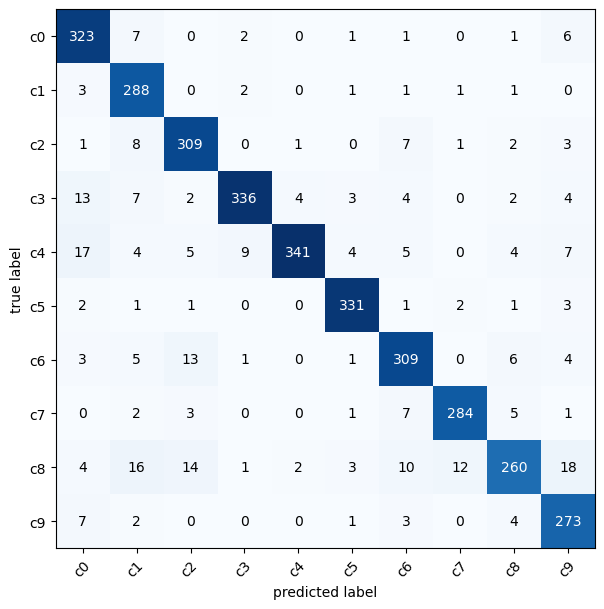

In [17]:
# 7. Get the model's performance metrics
model_2_pred_probs = model_2.predict(val_ds, verbose=1)
model_2_pred_classes = model_2_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_2_metrics = get_metrics(
    y_true=model_2_pred_classes,
    y_pred=y_val_labels,
    model_path=pathlib.Path(best_weights_path_model_2),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_2_metrics

In [18]:
# 8. Create submissions file
create_submission_csv(
    dataloader=test_dataloader,
    model=model_2,
    save_path=CONFIG.submission_dir,
    submission_csv_path=CONFIG.sample_submission_path,
)

[INFO] Predictions on dataloader completed.


  0%|          | 0/79726 [00:00<?, ?it/s]

[INFO] Saving submissions... File located at submissions/model_2_vgg_ft_08_01.csv


### Model 3
***Architecture***: Fine-tuned Inception-ResNet V2  
***Optimizer***: Adam optimizer with 0.001 learning rate  
***Epochs*** : 50  
***Callbacks*** : Early stopping, Model checkpointing  

In [19]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

# 1. Create the model
base_incep_resnet_model = applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
base_incep_resnet_model.trainable = False

LAYERS_TRAINALBLE = 10
for layer in base_incep_resnet_model.layers[-LAYERS_TRAINALBLE:]:
    layer.trainable = True

model_3 = tf.keras.Sequential(
    [
        layers.Input(shape=INPUT_SHAPE),
        base_incep_resnet_model,
        layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
        layers.Dense(1024, activation="relu", name="fcl1"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu", name="fcl2"),
        layers.Dropout(0.2),
        layers.Dense(CONFIG.num_classes, activation="softmax", name="output"),
    ],
    name="model_3_incep_resnet_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_3.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_3 = model_3.fit(
    train_ds,
    epochs=7,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
    callbacks=[
        create_model_checkpoint(model_name=model_3.name),
        create_early_stopping(patience=3),
    ],
)

219055592/219055592 [==============================] - 10s 0us/step
Epoch 1/7
596/596 [==============================] - ETA: 0s - loss: 2.3170 - accuracy: 0.1184
Epoch 1: val_loss improved from inf to 2.28534, saving model to models/model_3_incep_resnet_ft.h5
596/596 [==============================] - 362s 587ms/step - loss: 2.3170 - accuracy: 0.1184 - val_loss: 2.2853 - val_accuracy: 0.1337
Epoch 2/7
596/596 [==============================] - ETA: 0s - loss: 2.2838 - accuracy: 0.1322
Epoch 2: val_loss improved from 2.28534 to 2.26499, saving model to models/model_3_incep_resnet_ft.h5
596/596 [==============================] - 338s 567ms/step - loss: 2.2838 - accuracy: 0.1322 - val_loss: 2.2650 - val_accuracy: 0.1423
Epoch 3/7
596/596 [==============================] - ETA: 0s - loss: 2.2679 - accuracy: 0.1423
Epoch 3: val_loss improved from 2.26499 to 2.24422, saving model to models/model_3_incep_resnet_ft.h5
596/596 [==============================] - 334s 560ms/step - loss: 2.2679 -

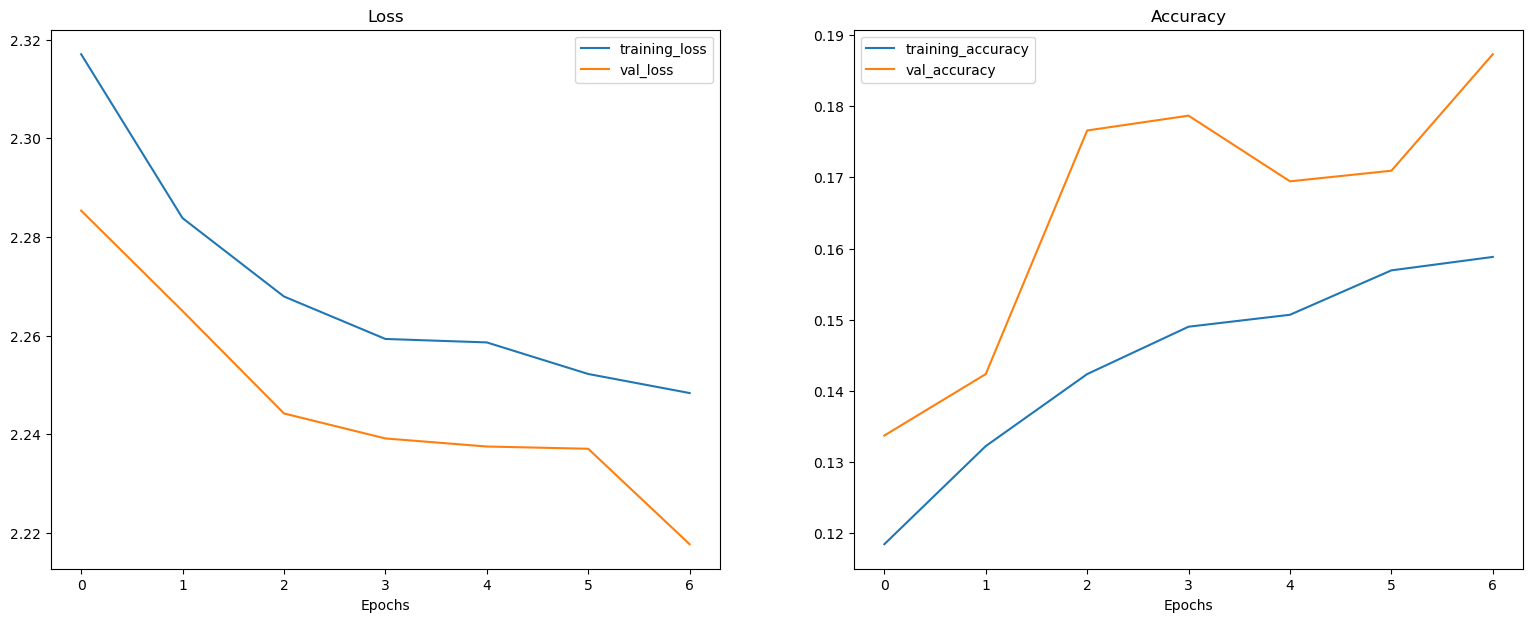

In [20]:
# 4. Plot model training performance
plot_loss_curves(history_model_3)

In [21]:
# 5. Loading the best weights
best_weights_path_model_3 = "/kaggle/working/models/model_3_incep_resnet_ft.h5"
model_3 = models.load_model(best_weights_path_model_3)

In [22]:
# 6. Evaluate on test data
model_3.evaluate(val_ds)

105/105 [==============================] - 53s 471ms/step - loss: 2.2156 - accuracy: 0.1817


[2.2156448364257812, 0.18165574967861176]

105/105 [==============================] - 52s 463ms/step


{'Accuracy': 0.19088743299583086,
 'Precision': 0.19088743299583086,
 'Recall': 0.19088743299583086,
 'F1-score': 0.19088743299583086,
 'Size (MB)': 229}

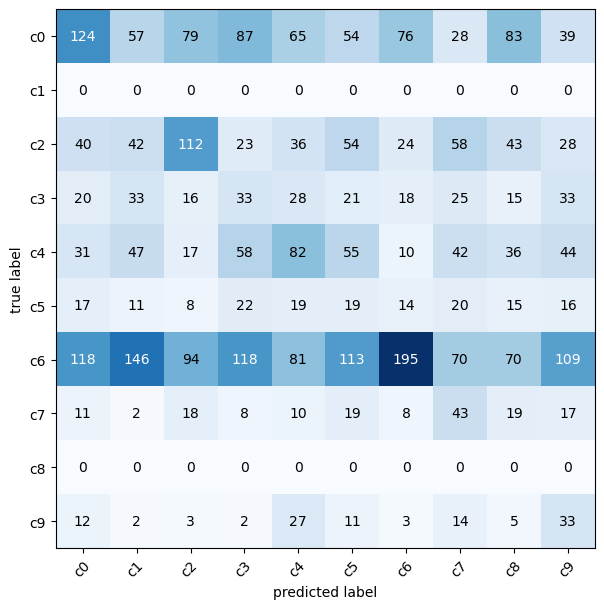

In [23]:
# 7. Get the model's performance metrics
model_3_pred_probs = model_3.predict(val_ds, verbose=1)
model_3_pred_classes = model_3_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_3_metrics = get_metrics(
    y_true=model_3_pred_classes,
    y_pred=y_val_labels,
    model_path=pathlib.Path(best_weights_path_model_3),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_3_metrics

In [24]:
# 8. Create submissions file
create_submission_csv(
    dataloader=test_dataloader,
    model=model_3,
    save_path=CONFIG.submission_dir,
    submission_csv_path=CONFIG.sample_submission_path,
)

[INFO] Predictions on dataloader completed.


  0%|          | 0/79726 [00:00<?, ?it/s]

[INFO] Saving submissions... File located at submissions/model_3_incep_resnet_ft_08_01.csv


### Model 4
***Architecture***: Fine-tuned EfficientNetB0  
***Optimizer***: Adam optimizer with 0.001 learning rate  
***Epochs*** : 50  
***Callbacks*** : Early stopping, Model checkpointing  

In [25]:
# 0. Set random seed
tf.random.set_seed(CONFIG.seed)
INPUT_SHAPE = (CONFIG.image_size, CONFIG.image_size, 3)

# 1. Create the model
base_effnetb3_model = applications.EfficientNetB3(include_top=False, weights="imagenet")
base_effnetb3_model.trainable = False

LAYERS_TRAINALBLE = 10
for layer in base_effnetb3_model.layers[-LAYERS_TRAINALBLE:]:
    layer.trainable = True

model_4 = tf.keras.Sequential(
    [
        layers.Input(shape=INPUT_SHAPE),
        base_effnetb3_model,
        layers.GlobalAveragePooling2D(name="global_average_pooling_layer"),
        layers.Dense(1024, activation="relu", name="fcl1"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="relu", name="fcl2"),
        layers.Dropout(0.2),
        layers.Dense(CONFIG.num_classes, activation="softmax", name="output"),
    ],
    name="model_4_effnetb7_ft",
)

# 2. Compile the model
LEARNING_RATE = 1e-3
optim = optimizers.Adam(learning_rate=LEARNING_RATE)
model_4.compile(
    loss="sparse_categorical_crossentropy", optimizer=optim, metrics=["accuracy"]
)

# 3. Fit the model
history_model_4 = model_4.fit(
    train_ds,
    epochs=7,
    validation_data=val_ds,
    verbose=CONFIG.verbose,
)

43941136/43941136 [==============================] - 3s 0us/step
Epoch 1/7


2024-01-08 16:02:46.991058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4_effnetb7_ft/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


596/596 [==============================] - 338s 549ms/step - loss: 0.7446 - accuracy: 0.7448 - val_loss: 0.2524 - val_accuracy: 0.9113
Epoch 2/7
596/596 [==============================] - 323s 542ms/step - loss: 0.3835 - accuracy: 0.8729 - val_loss: 0.1651 - val_accuracy: 0.9455
Epoch 3/7
596/596 [==============================] - 323s 541ms/step - loss: 0.2820 - accuracy: 0.9100 - val_loss: 0.1247 - val_accuracy: 0.9598
Epoch 4/7
596/596 [==============================] - 325s 545ms/step - loss: 0.2470 - accuracy: 0.9193 - val_loss: 0.1208 - val_accuracy: 0.9652
Epoch 5/7
596/596 [==============================] - 323s 542ms/step - loss: 0.2146 - accuracy: 0.9276 - val_loss: 0.1001 - val_accuracy: 0.9655
Epoch 6/7
596/596 [==============================] - 324s 544ms/step - loss: 0.1908 - accuracy: 0.9370 - val_loss: 0.0883 - val_accuracy: 0.9714
Epoch 7/7
596/596 [==============================] - 329s 552ms/step - loss: 0.1847 - accuracy: 0.9402 - val_loss: 0.0683 - val_accuracy: 0.

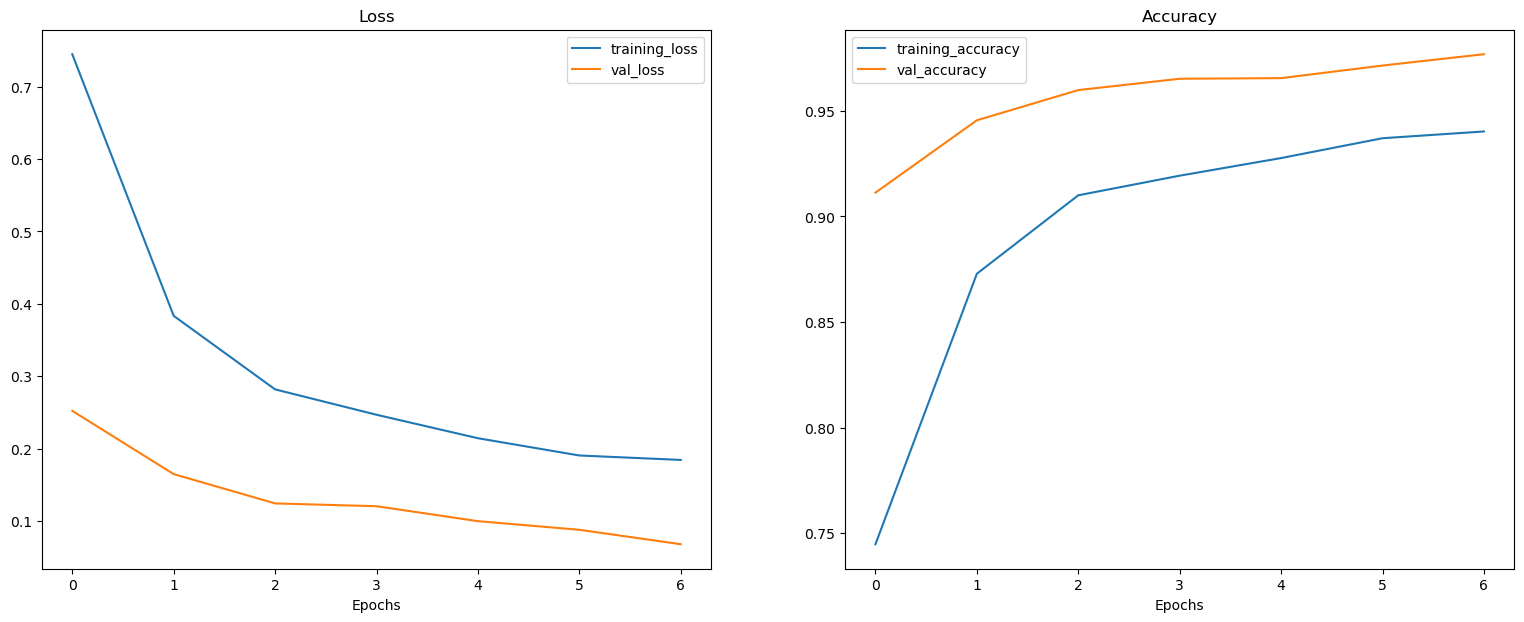

In [26]:
# 4. Plot model training performance
plot_loss_curves(history_model_4)

In [27]:
# 5. Loading the best weights
best_weights_path_model_4 = "/kaggle/working/models/model_4_effnetb3_ft.h5"
# model_4 = models.load_model(best_weights_path_model_4)

In [28]:
# 6. Evaluate on test data
model_4.evaluate(val_ds)

105/105 [==============================] - 52s 494ms/step - loss: 0.0778 - accuracy: 0.9744


[0.0777764841914177, 0.9743894934654236]

105/105 [==============================] - 54s 490ms/step


{'Accuracy': 0.9755807027992853,
 'Precision': 0.9755807027992853,
 'Recall': 0.9755807027992853,
 'F1-score': 0.9755807027992853,
 'Size (MB)': 0}

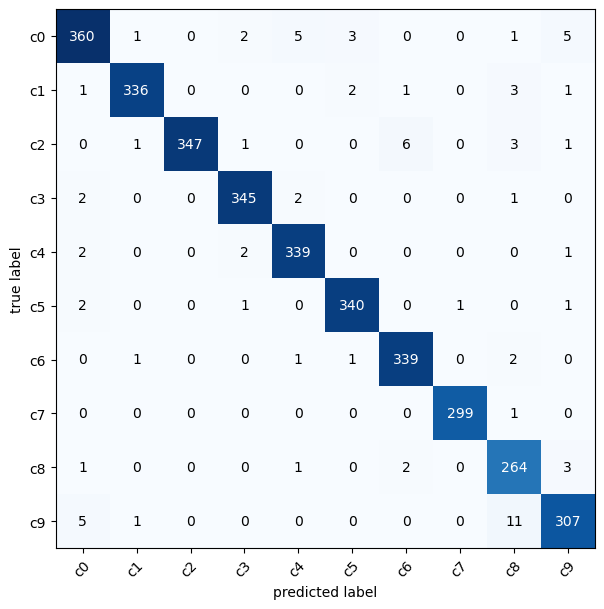

In [29]:
# 7. Get the model's performance metrics
model_4_pred_probs = model_4.predict(val_ds, verbose=1)
model_4_pred_classes = model_4_pred_probs.argmax(axis=1).reshape(-1).astype("int")

model_4_metrics = get_metrics(
    y_true=model_4_pred_classes,
    y_pred=y_val_labels,
    model_path=pathlib.Path(''),
    plot_confusion_matrix=True,
    classes=CONFIG.classes,
)
model_4_metrics

In [30]:
# 8. Create submissions file
create_submission_csv(
    dataloader=test_dataloader,
    model=model_4,
    save_path=CONFIG.submission_dir,
    submission_csv_path=CONFIG.sample_submission_path,
)

[INFO] Predictions on dataloader completed.


  0%|          | 0/79726 [00:00<?, ?it/s]

[INFO] Saving submissions... File located at submissions/model_4_effnetb7_ft_08_01.csv


## Step 4: Conclude modelling experiments
- Evalaute all models' performance
- Get the best model

In [31]:
# Dataframe of results-
results_df = pd.DataFrame({model_1.name: model_1_metrics,
                           model_2.name: model_2_metrics,
                           model_3.name: model_3_metrics,
                           model_4.name: model_4_metrics,}).T

results_df["Size (MB)"] = results_df["Size (MB)"] / results_df["Size (MB)"].max()
results_df

,Accuracy,Precision,Recall,F1-score,Size (MB)
model_1_resnet_ft,0.916021,0.916021,0.916021,0.916021,0.510917
model_2_vgg_ft,0.909470,0.909470,0.909470,0.909470,0.283843
model_3_incep_resnet_ft,0.190887,0.190887,0.190887,0.190887,1.000000
model_4_effnetb7_ft,0.975581,0.975581,0.975581,0.975581,0.000000


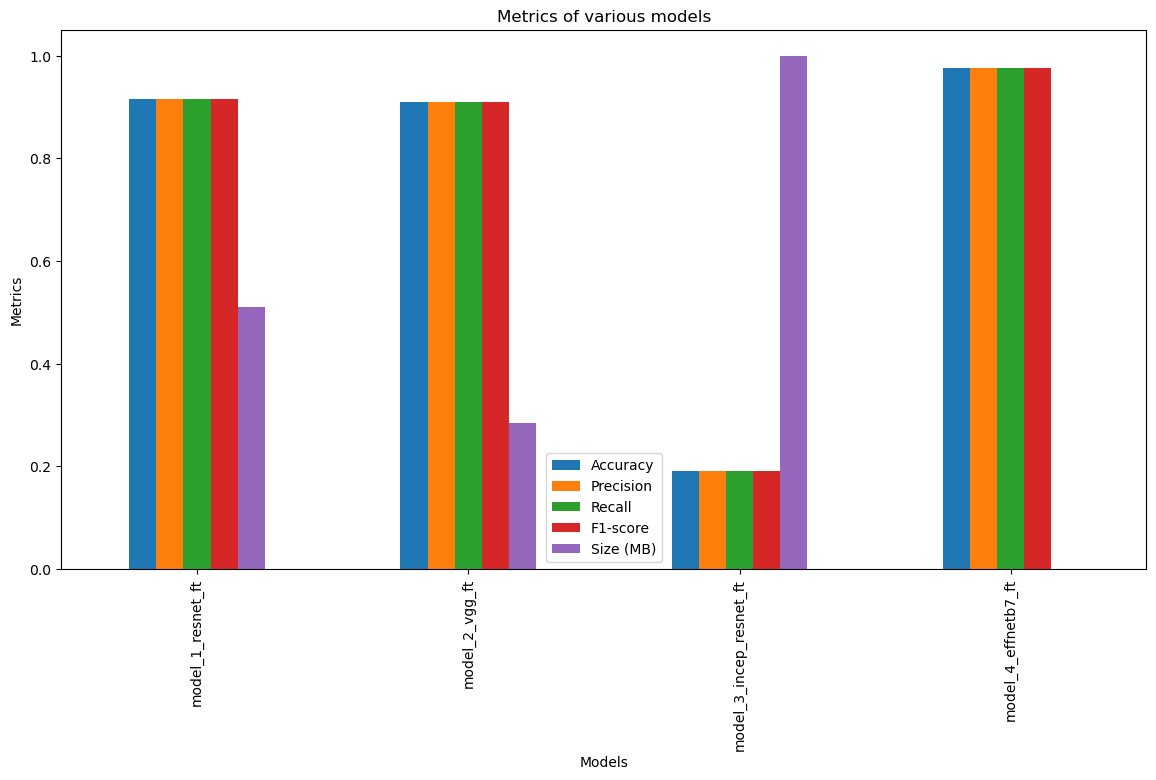

In [32]:
results_df[["Accuracy", "Precision", "Recall", "F1-score", "Size (MB)"]].plot(kind="bar", figsize=(14,7), title="Metrics of various models", ylabel="Metrics", xlabel="Models");

## References
- https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/overview
- https://www.tensorflow.org/tutorials/images/transfer_learning